In [1]:
import os

if is_colab := True:
    from google.colab import drive
    drive.mount('/content/drive')

    if not os.path.exists("/content/diffusion_playground"):
        ! git clone https://github.com/okami361/diffusion_playground
    else:
      ! git pull

    %cd /content/diffusion_playground

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
fatal: not a git repository (or any of the parent directories): .git
/content/diffusion_playground


In [2]:
import io
import contextlib
import json

from VAE.VAE import VAE
from VAE.GAN import GAN
from tools.tools import generate_config
from tools.dataset import imagenette_loaders

In [3]:
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [5]:
config = generate_config(
    exp_number = 9,
    name = 'basic_implementation',
    output_path = 'drive/MyDrive/latent_diffusion/2025_01_13/models/VAE',
    dataset = 'imagenette2-160',
    description = 'Increasing the complexity of the autoencoder. Trying 1e-5 perpetual loss.',
    image_resolution = 160,
    latent_resolution = 40,
    latent_channels = 3,
    batch_size = 64,
    learning_rate = 1e-3,
    num_epochs = 20
)

In [6]:
if not os.path.exists(f"{config['output_path']}/experiment_{config['exp_number']}"):
    os.makedirs(f"{config['output_path']}/experiment_{config['exp_number']}")

filename = f"{config['output_path']}/experiment_{config['exp_number']}.json"

In [7]:
train_loader, test_loader = imagenette_loaders(config=config)

In [8]:
def kl_divergence(mu, logvar):
    # Calculate KL divergence
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return kl.mean()

def reconstruction_loss(recon_x, x):
    assert recon_x.shape == x.shape, f"Shape mismatch: recon_x shape {recon_x.shape}, x shape {x.shape}"

    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    return recon_loss

In [9]:
def train_discriminator(model_gan, optimizer_discriminator, data):
    model_gan.model_vae.eval()
    model_gan.model_discriminator.train()

    optimizer_discriminator.zero_grad()

    with torch.no_grad():
        recon_x, _, _ = model_gan.model_vae(data)

    real_pred = model_gan.discriminator(data)
    fake_pred = model_gan.discriminator(recon_x)

    real_loss = F.binary_cross_entropy(real_pred, torch.ones_like(real_pred))
    fake_loss = F.binary_cross_entropy(fake_pred, torch.zeros_like(fake_pred))

    loss = real_loss + fake_loss

    loss.backward()
    optimizer_discriminator.step()

    return loss

In [10]:
def train_vae(model_gan, optimizer_vae, data):

    model_gan.model_vae.train()
    model_gan.model_discriminator.eval()

    optimizer_vae.zero_grad()

    # Freeze discriminator within the context
    for param in model_gan.model_discriminator.parameters():
        param.requires_grad = False

    recon_data, mu, logvar, y = model_gan(data)

    # Compute loss components
    kl = kl_divergence(mu, logvar)
    recon_loss = reconstruction_loss(recon_data, data)

    data_features = model_gan.discriminator_features(data)
    recon_features = model_gan.discriminator_features(recon_data)
    perceptual_loss = F.mse_loss(recon_features, data_features)

    # Combine losses with appropriate weighting
    loss = recon_loss + 1e-5*perceptual_loss + 1e-6 * kl

    # Backward pass and optimization
    loss.backward()
    optimizer_vae.step()

    for param in model_gan.model_discriminator.parameters():
        param.requires_grad = True

    return recon_loss, 1e-6 *kl, 1e-5*perceptual_loss

In [11]:
def train(model_gan, epoch, optimizer_vae, optimizer_discriminator, data_loader):
    total_discriminator_loss = 0

    total_recon_loss = 0
    total_kl_divergence = 0
    total_percetual_loss = 0

    for batch_idx, data in enumerate(data_loader):
        data = data.to(device)

        discriminator_loss = train_discriminator(model_gan, optimizer_discriminator, data)
        recon_loss, kl_divergence, perceptual_loss = train_vae(model_gan, optimizer_vae, data)

        total_discriminator_loss += discriminator_loss
        total_recon_loss += recon_loss
        total_kl_divergence += kl_divergence
        total_percetual_loss += perceptual_loss

    avg_discriminator_loss = total_discriminator_loss / len(data_loader.dataset)
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)
    avg_kl_divergence = total_kl_divergence / len(data_loader.dataset)
    avg_percetual_loss = total_percetual_loss / len(data_loader.dataset)

    avg_loss = avg_discriminator_loss + avg_recon_loss + avg_kl_divergence + avg_percetual_loss
    avg_vae_loss = avg_recon_loss + avg_kl_divergence + avg_percetual_loss

    print(f'====> Epoch: {epoch}')
    print(f'Average loss: {avg_loss:.8f}')
    print(f'Discriminator loss: {avg_discriminator_loss:.8f}')
    print(f'VAE loss: {avg_vae_loss:.8f}')
    print("--------------------")
    print(f'Reconstruction loss: {avg_recon_loss:.8f}')
    print(f'KL divergence: {avg_kl_divergence:.8f}')
    print(f'Perceptual loss: {avg_percetual_loss:.8f}')
    return avg_loss.detach().cpu().item()

In [12]:
if is_train := True:
    model_gan = GAN(config)

    optimizer_vae = optim.Adam(model_gan.model_vae.parameters(), lr=config['learning_rate'])
    optimizer_discriminator = optim.Adam(model_gan.model_discriminator.parameters(), lr=config['learning_rate'])

    model_gan.to(device)
    print('==================================')
    print(f'Training model {config["name"]}')
    print('==================================')

    summary_str = io.StringIO()
    with contextlib.redirect_stdout(summary_str):
        summary(model_gan.model_vae, input_size = (3, config['image_resolution'], config['image_resolution']))
    config['summary'] = summary_str.getvalue()

    for epoch in range(1, config['num_epochs'] + 1):
        config['loss'] = train(model_gan, epoch, optimizer_vae, optimizer_discriminator, train_loader)

    # Open the file in write mode and use json.dump() to save the data
    with open(filename, 'w') as file:
        json.dump(config, file, indent=4)

    torch.save(model_gan.model_vae, f"{config['output_path']}/experiment_{config['exp_number']}/{config['name']}.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training model basic_implementation
====> Epoch: 1
Average loss: 0.00084241
Discriminator loss: 0.00067043
VAE loss: 0.00017198
--------------------
Reconstruction loss: 0.00017112
KL divergence: 0.00000037
Perceptual loss: 0.00000048
====> Epoch: 2
Average loss: 0.00716895
Discriminator loss: 0.00695670
VAE loss: 0.00021226
--------------------
Reconstruction loss: 0.00013733
KL divergence: 0.00000078
Perceptual loss: 0.00007415
====> Epoch: 3
Average loss: 0.00010325
Discriminator loss: 0.00002148
VAE loss: 0.00008177
--------------------
Reconstruction loss: 0.00008111
KL divergence: 0.00000064
Perceptual loss: 0.00000002
====> Epoch: 4
Average loss: 0.00008145
Discriminator loss: 0.00001097
VAE loss: 0.00007048
--------------------
Reconstruction loss: 0.00006994
KL divergence: 0.00000052
Perceptual loss: 0.00000002
====> Epoch: 5
Average loss: 0.00006514
Discriminator loss: 0.00000643
VAE loss: 0.00005871
--------------------
Reconstruction loss: 0.00005823
KL divergence: 0.000000

# Test

<ipython-input-14-4c509ea364f9>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


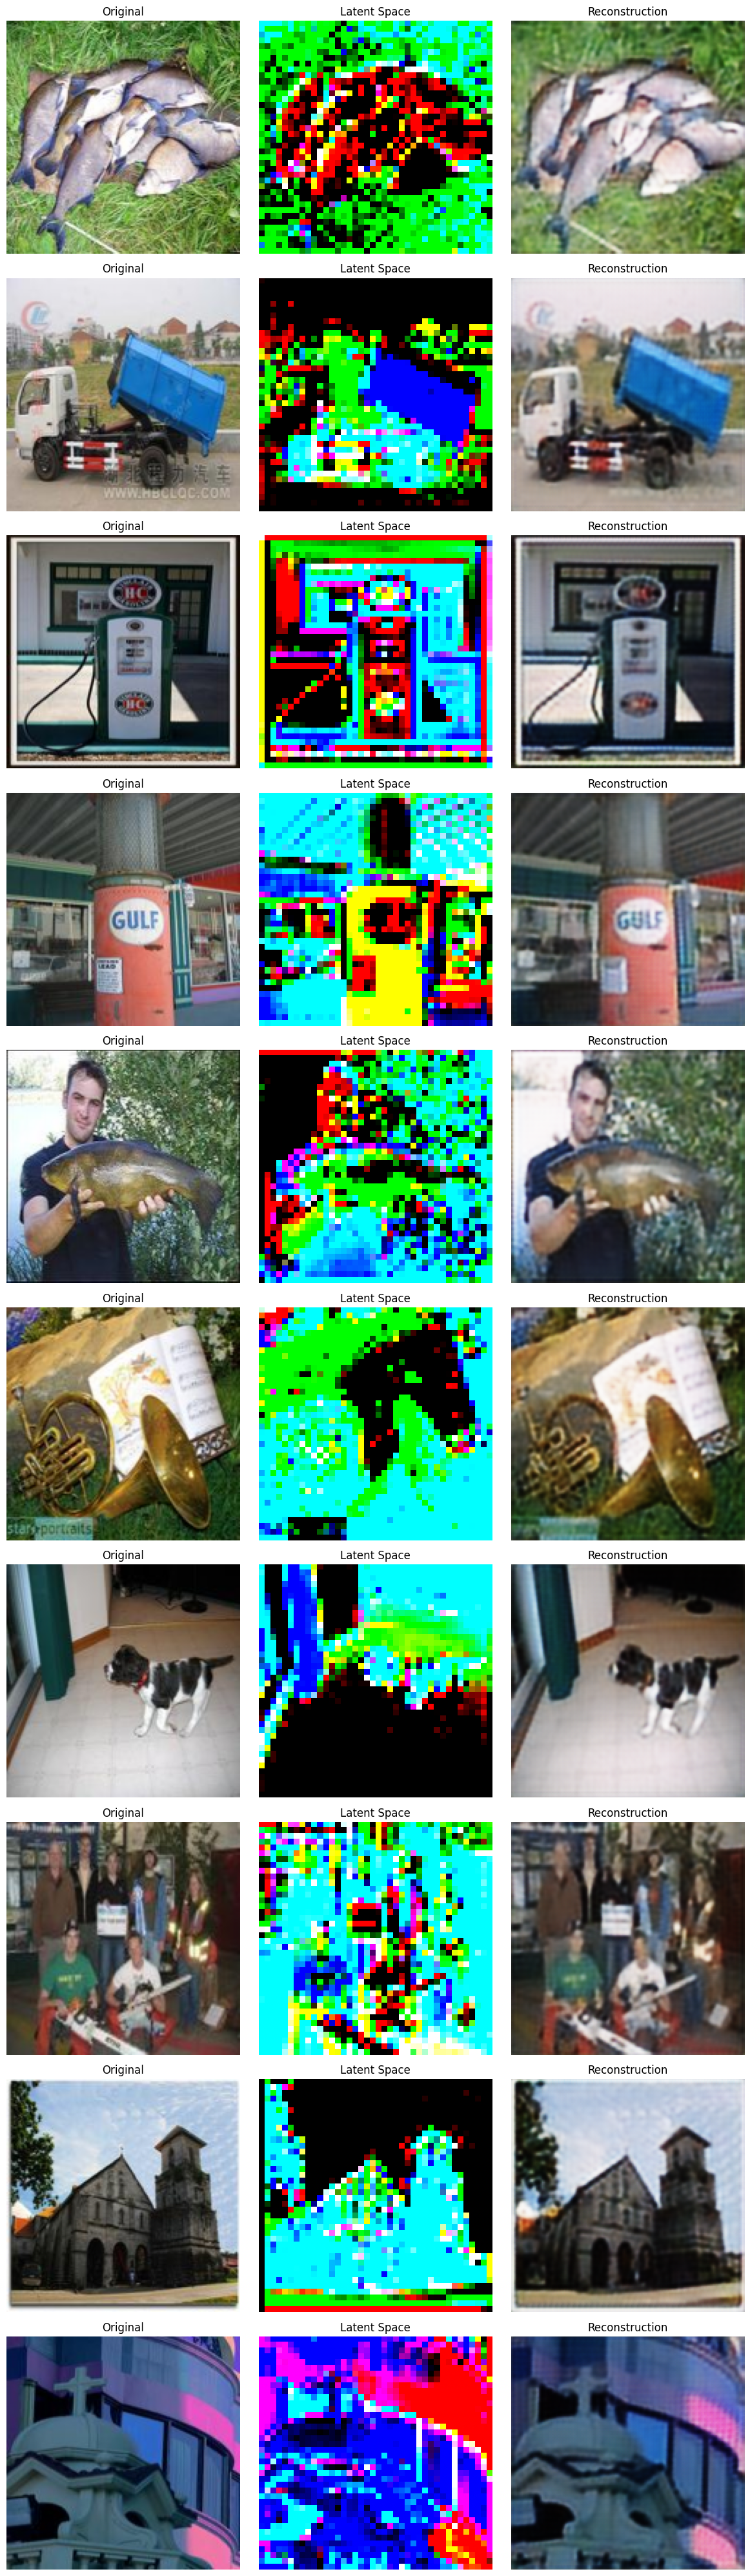

In [14]:
import matplotlib.pyplot as plt

# Load the VAE model
model_path = f'{config["output_path"]}/experiment_{config["exp_number"]}/{config["name"]}.pth'
model = torch.load(model_path)

# Set the model to evaluation mode
model.eval()

# Get a batch of test data
data_iter = iter(test_loader)
data = next(data_iter)

# Move the data to the device
data = data.to(device)

# Pass the data through the VAE model
with torch.no_grad():
    recon_data, mu, logvar = model(data)

# Determine the number of images to show
num_images = 10  # Change this value to configure the number of images to show

# Plot the original, latent space, and reconstruction for each image
fig, axes = plt.subplots(nrows=num_images, ncols=3, figsize=(12, 4*num_images))

for i in range(num_images):
    # Plot the original image
    axes[i, 0].imshow(data[i].permute(1, 2, 0).cpu())
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # Plot the latent space
    axes[i, 1].imshow(mu[i].permute(1, 2, 0).cpu(), cmap='hot')
    axes[i, 1].set_title('Latent Space')
    axes[i, 1].axis('off')

    # Plot the reconstruction
    axes[i, 2].imshow(recon_data[i].permute(1, 2, 0).cpu())
    axes[i, 2].set_title('Reconstruction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()